In [1]:
#Install necessary software
pip install astroquery

     |████████████████████████████████| 4.5 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 885 kB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 18.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
#Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from scipy.optimize import curve_fit

In [62]:
#Search the Gaia DR2 Database for stars within a parallax range around the Alpha Centauri system
query = """
SELECT gaia.pmra, gaia.pmdec, gaia.source_id, gaia.parallax, gaia.ra, gaia.dec
FROM gaiadr2.gaia_source AS gaia
WHERE parallax BETWEEN 768.5004 - 2  AND 768.5004 + 2
"""

#Submit the query
job = Gaia.launch_job_async(query)

#Print results
results = job.get_results()
print(results)

INFO: Query finished. [astroquery.utils.tap.core]
        pmra              pmdec            source_id           parallax             ra                 dec        
      mas / yr           mas / yr                                mas               deg                 deg        
------------------- ----------------- ------------------- ----------------- ------------------ -------------------
 1190.5628289506492 995.3718787089431 4062918807322638848 767.9115731289477 271.47445270436447  -27.80115581563037
-3781.3059409680022 769.7656533486586 5853498713160606720 768.5003653333918 217.39346574260355  -62.67618210292382
 -492.8483504932461 448.8730135266951 4048918416551298560 769.0094658362417  273.7515204944334 -31.508122017088088


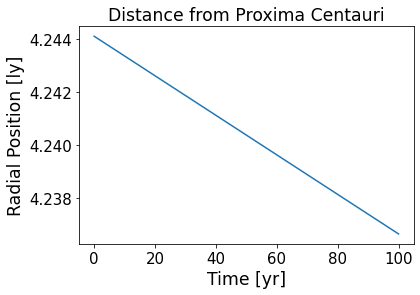

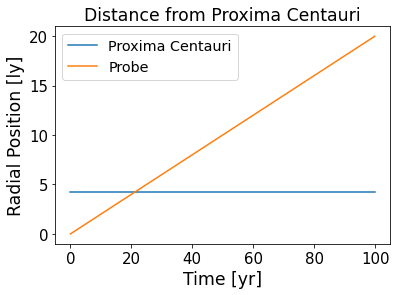

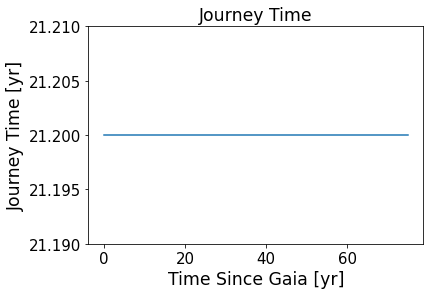

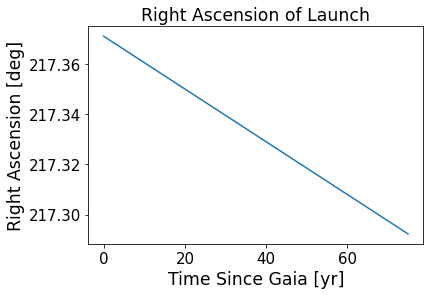

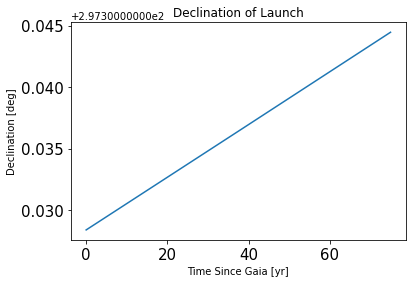

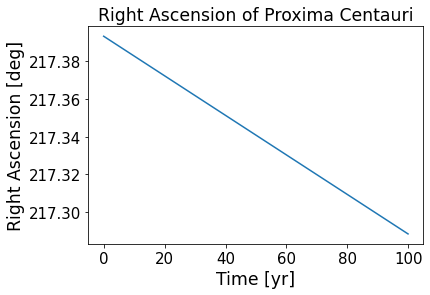

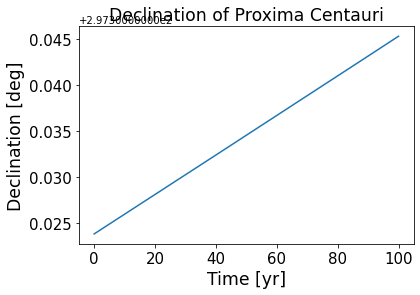

In [272]:
#Probe Timescale Plots

#5853498713160606720 is the source id for Proxima Centauri, the closest star to us in the Alpha Centauri system. 

#Relevant Constants
rad_per_mas = 4.8481368e-9
m_per_AU = 1.496e11
ly_per_m = 1.057e-16
sec_per_year = 3.154e7 
G = 6.67e-11 
M_sun = 1.9891e30 # kg
vtang_Earth = 29780
v_probe = .2 * 3e8

#Proxima Centauri Variables
pr_alpha = (1 / (results[1][3] * rad_per_mas)) * m_per_AU  # initial radius from sun
pra_alpha = results[1][4] * np.pi / 180 # initial right ascension
pdec_alpha = results[1][5] * np.pi / 180 # initial declination
pmra = results[1][0] * rad_per_mas / (sec_per_year) # initial angular velocity of right ascension
pmdec = results[1][1] * rad_per_mas / (sec_per_year) # initial angular velocity of declination
pmr = -22400 # initial radial velocity
x = pr_alpha * np.cos(pdec_alpha) * np.cos(pra_alpha)
y = pr_alpha * np.cos(pdec_alpha) * np.sin(pra_alpha)
z = pr_alpha * np.sin(pdec_alpha)
dx_dt = pmr * np.cos(pdec_alpha) * np.cos(pra_alpha) - pr_alpha * pmra * np.sin(pra_alpha) * np.cos(pdec_alpha) - pr_alpha * np.cos(pra_alpha) * pmdec * np.sin(pdec_alpha)
dy_dt = pmr * np.cos(pdec_alpha) * np.sin(pra_alpha) + pr_alpha * pmra * np.cos(pra_alpha) * np.cos(pdec_alpha) - pr_alpha * np.sin(pra_alpha) * pmdec * np.sin(pdec_alpha)
dz_dt = pmr * np.sin(pdec_alpha) + pr_alpha * pmdec * np.cos(pdec_alpha)
ax = -G * M_sun * x / ((x ** 2 + y ** 2 + z ** 2) ** 3)
ay = -G * M_sun * y / ((x ** 2 + y ** 2 + z ** 2) ** 3)
az = -G * M_sun * z / ((x ** 2 + y ** 2 + z ** 2) ** 3)

#Proxima Centauri Lists
x_list = []
y_list = []
z_list = []
pra_list = []
pdec_list = []

#Probe Function
def r_probe(t, t_since_gaia):
    return (v_probe + vtang_Earth) * (t - t_since_gaia)

t_max = (100)*sec_per_year
dt = 3.154e6
t_list = np.arange(0, t_max, dt)
for t in np.arange(0, t_max, dt):
    x += dx_dt * dt
    y += dy_dt * dt
    z += dz_dt * dt
    dx_dt += ax * dt
    dy_dt += ay * dt
    dz_dt += az * dt
    pra_alpha = np.arctan(y / x) + np.pi
    pdec_alpha = np.arcsin(z / np.sqrt(x ** 2 + y ** 2 + z ** 2))
    t_probe = (v_probe + vtang_Earth - np.sqrt(dx_dt ** 2 + dy_dt ** 2 + dz_dt ** 2) - (v_probe + vtang_Earth - np.sqrt(dx_dt ** 2 + dy_dt ** 2 + dz_dt ** 2))) / (np.sqrt(ax ** 2 + ay ** 2 + az ** 2))
    t_probe_list = np.append(t_probe_list, t_probe)
    x_list = np.append(x_list, x)
    y_list = np.append(y_list, y)
    z_list = np.append(z_list, z)
    pra_list = np.append(pra_list, pra_alpha)
    pdec_list = np.append(pdec_list, pdec_alpha)
    

r_list = np.sqrt(x_list ** 2 + y_list ** 2 + z_list ** 2)

plt.title('Distance from Proxima Centauri', fontsize = 'xx-large')
plt.xlabel('Time [yr]', fontsize = 'xx-large')
plt.ylabel('Radial Position [ly]', fontsize = 'xx-large')
plt.tick_params(labelsize = 15)
plt.plot(t_list / sec_per_year, r_list * ly_per_m)
plt.savefig(fname = 'PC_Distance.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()


plt.title('Distance from Proxima Centauri', fontsize = 'xx-large')
plt.xlabel('Time [yr]', fontsize = 'xx-large')
plt.ylabel('Radial Position [ly]', fontsize = 'xx-large')
plt.tick_params(labelsize = 15)
plt.plot(t_list / sec_per_year, r_list * ly_per_m, label = 'Proxima Centauri')
plt.plot(t_list / sec_per_year, r_probe(t_list, 0) * ly_per_m, label = 'Probe')
plt.legend(fontsize = 'x-large')
plt.savefig(fname = 'Probe_Distance.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

journey_time_list = []
time_since_gaia = []
probe_dec_list = []
probe_ra_list = []
for i in range(0, len(t_list[0:np.abs(75 - t_list / sec_per_year).argmin()])):
    intersection_arg = np.abs(r_probe(t_list, t_list[i]) * ly_per_m - r_list * ly_per_m).argmin()
    journey_time_list = np.append(journey_time_list, t_list[intersection_arg] - t_list[i])
    time_since_gaia = np.append(time_since_gaia, t_list[i])
    probe_dec_list = np.append(probe_dec_list, pdec_list[intersection_arg])
    probe_ra_list = np.append(probe_ra_list, pra_list[intersection_arg])
    
    
plt.title("Journey Time", fontsize = 'xx-large')
plt.ylabel("Journey Time [yr]", fontsize = 'xx-large')
plt.xlabel("Time Since Gaia [yr]", fontsize = 'xx-large')
plt.plot(time_since_gaia / sec_per_year, journey_time_list / sec_per_year)
plt.tick_params(labelsize = 15)
plt.ylim(21.19, 21.21)
plt.savefig(fname = 'Journey.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

plt.title("Right Ascension of Launch", fontsize = 'xx-large')
plt.ylabel("Right Ascension [deg]", fontsize = 'xx-large')
plt.xlabel("Time Since Gaia [yr]", fontsize = 'xx-large')
plt.tick_params(labelsize = 15)
plt.plot(time_since_gaia / sec_per_year, (probe_ra_list * 180 / np.pi) % 360)
plt.savefig(fname = 'Right_Ascension.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

plt.title("Declination of Launch")
plt.ylabel("Declination [deg]")
plt.xlabel("Time Since Gaia [yr]")
plt.tick_params(labelsize = 15)
plt.plot(time_since_gaia / sec_per_year, (probe_dec_list * 180 / np.pi) % 360)
plt.savefig(fname = 'Declination.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

plt.title('Right Ascension of Proxima Centauri', fontsize = 'xx-large')
plt.xlabel('Time [yr]', fontsize = 'xx-large')
plt.ylabel('Right Ascension [deg]', fontsize = 'xx-large')
plt.tick_params(labelsize = 15)
plt.plot(t_list / sec_per_year, (pra_list * 180 / np.pi) % 360)
plt.savefig(fname = 'PC_Right Ascension.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

plt.title('Declination of Proxima Centauri', fontsize = 'xx-large')
plt.xlabel('Time [yr]', fontsize = 'xx-large')
plt.ylabel('Declination [deg]', fontsize = 'xx-large')
plt.tick_params(labelsize = 15)
plt.plot(t_list / sec_per_year, (pdec_list * 180 / np.pi) % 360)
plt.savefig(fname = 'PC_Declination.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()



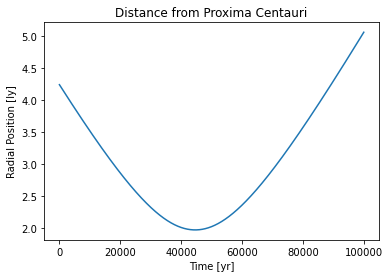

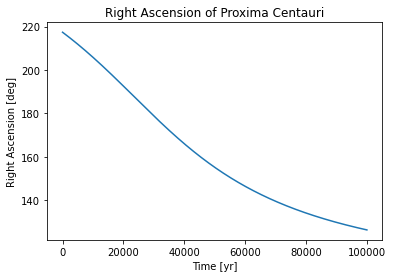

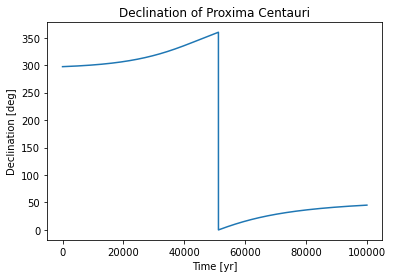

In [277]:
#Longer Timescale Plots

#Relevant Constants
rad_per_mas = 4.8481368e-9
m_per_AU = 1.496e11
ly_per_m = 1.057e-16
sec_per_year = 3.154e7 
G = 6.67e-11 
M_sun = 1.9891e30 # kg

#Proxima Centauri Variables
pr_alpha = (1 / (results[1][3] * rad_per_mas)) * m_per_AU  # initial radius from sun
pra_alpha = results[1][4] * np.pi / 180 # initial right ascension
pdec_alpha = results[1][5] * np.pi / 180 # initial declination
pmra = results[1][0] * rad_per_mas / (sec_per_year) # initial angular velocity of right ascension
pmdec = results[1][1] * rad_per_mas / (sec_per_year) # initial angular velocity of declination
pmr = -22400 # initial radial velocity
x = pr_alpha * np.cos(pdec_alpha) * np.cos(pra_alpha)
y = pr_alpha * np.cos(pdec_alpha) * np.sin(pra_alpha)
z = pr_alpha * np.sin(pdec_alpha)
dx_dt = pmr * np.cos(pdec_alpha) * np.cos(pra_alpha) - pr_alpha * pmra * np.sin(pra_alpha) * np.cos(pdec_alpha) - pr_alpha * np.cos(pra_alpha) * pmdec * np.sin(pdec_alpha)
dy_dt = pmr * np.cos(pdec_alpha) * np.sin(pra_alpha) + pr_alpha * pmra * np.cos(pra_alpha) * np.cos(pdec_alpha) - pr_alpha * np.sin(pra_alpha) * pmdec * np.sin(pdec_alpha)
dz_dt = pmr * np.sin(pdec_alpha) + pr_alpha * pmdec * np.cos(pdec_alpha)
ax = -G * M_sun * x / ((x ** 2 + y ** 2 + z ** 2) ** 3)
ay = -G * M_sun * y / ((x ** 2 + y ** 2 + z ** 2) ** 3)
az = -G * M_sun * z / ((x ** 2 + y ** 2 + z ** 2) ** 3)

#Proxima Centauri Lists
x_list = []
y_list = []
z_list = []
pra_list = []
pdec_list = []

t_max = (100000)*sec_per_year
dt = 3.154e8
t_list = np.arange(0, t_max, dt)
for t in np.arange(0, t_max, dt):
    x += dx_dt * dt
    y += dy_dt * dt
    z += dz_dt * dt
    dx_dt += ax * dt
    dy_dt += ay * dt
    dz_dt += az * dt
    pra_alpha = np.arctan(y / x) + np.pi
    pdec_alpha = np.arcsin(z / np.sqrt(x ** 2 + y ** 2 + z ** 2))
    x_list = np.append(x_list, x)
    y_list = np.append(y_list, y)
    z_list = np.append(z_list, z)
    pra_list = np.append(pra_list, pra_alpha)
    pdec_list = np.append(pdec_list, pdec_alpha)
    

r_list = np.sqrt(x_list ** 2 + y_list ** 2 + z_list ** 2)

plt.title('Distance from Proxima Centauri')
plt.xlabel('Time [yr]')
plt.ylabel('Radial Position [ly]')
plt.plot(t_list / sec_per_year, r_list * ly_per_m)
plt.savefig(fname = 'Distance_Long.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

plt.title('Right Ascension of Proxima Centauri')
plt.xlabel('Time [yr]')
plt.ylabel('Right Ascension [deg]')
plt.plot(t_list / sec_per_year, (pra_list * 180 / np.pi) % 360)
plt.savefig(fname = 'PC_Ra_Long.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

plt.title('Declination of Proxima Centauri')
plt.xlabel('Time [yr]')
plt.ylabel('Declination [deg]')
plt.plot(t_list / sec_per_year, (pdec_list * 180 / np.pi) % 360)
plt.savefig(fname = 'PC_Dec_Long.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()

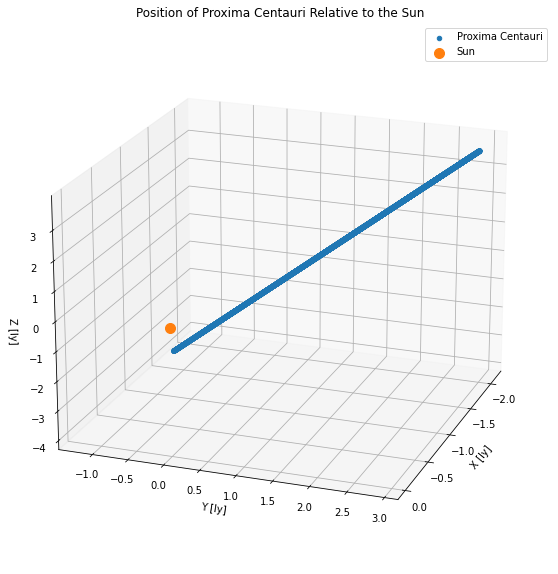

In [276]:
# 3D Plot

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.set_xlabel('X [ly]')
ax.set_ylabel('Y [ly]')
ax.set_zlabel('Z [ly]')
ax.set_title('Position of Proxima Centauri Relative to the Sun')

ax.scatter3D(x_list * ly_per_m, y_list * ly_per_m, z_list * ly_per_m, label = 'Proxima Centauri')
ax.scatter3D(0, 0, 0, label = 'Sun', s = 100)
ax.view_init(20,20)
ax.legend()
plt.savefig(fname = 'PC_3D_Long.png', dpi = 'figure',  bbox_inches = 'tight')
plt.show()